 ## 1. Create validation and sample set

In [ ]:
%cd ~/nbs/lesson2/data/dogscats

### Create a valid folder and move 2000 random samples from the train folder

In [ ]:
%mkdir valid

In [ ]:
!find train/ -maxdepth 2 -type f | sort -R | head -n 2000 | xargs -I {} mv {} ~/nbs/lesson2/data/dogscats/valid/

### Create a sample folder

In [ ]:
%mkdir sample

### Copy 200 random samples from train for sample train

In [ ]:
%mkdir sample/train

In [ ]:
!find train/ -maxdepth 2 -type f | sort -R | head -n 200 | xargs -I {} cp {} ~/nbs/lesson2/data/dogscats/sample/train

### Copy 50 random samples from train for sample valid

In [ ]:
%mkdir sample/valid

In [ ]:
!find train/ -maxdepth 2 -type f | sort -R | head -n 50 | xargs -I {} cp {} ~/nbs/lesson2/data/dogscats/sample/valid

### Move images to appropriate directories

In [ ]:
%mkdir valid/dogs
%mkdir valid/cats

In [ ]:
%mv valid/dog.*.jpg valid/dogs
%mv valid/cat.*.jpg valid/cats

In [ ]:
cd ./sample
%mkdir train/dogs
%mkdir train/cats
%mkdir valid/dogs
%mkdir valid/cats

In [ ]:
cd ./train
%mv dog.*.jpg dogs
%mv cat.*.jpg cats
cd ../valid
%mv dog.*.jpg dogs
%mv dog.*.jpg cats
cd ..

## 3. Finetune and train

### Create unknown subdirectory in test data and move images to it

In [ ]:
%mkdir ./test/unknown
%mv  ./test/*.jpg  ./test/unknown/

In [ ]:
%cd ~/nbs/lesson2
%matplotlib inline

In [8]:
path ="./data/dogscats/"
#path="./data/dogscats/sample/"

In [16]:
from __future__ import division, print_function
import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
import utils; reload(utils)  
from utils import *
from vgg16 import Vgg16
vgg = Vgg16()

In [4]:
# to finetune vgg16, call vgg.finetune and vgg.fit by this order.
# val_batches is a batch for finetune validation
# epoch is one full pass through the training data
batch_size = 64
batches = vgg.get_batches(path + 'train', batch_size=batch_size)
val_batches = vgg.get_batches(path + 'valid', batch_size=batch_size)
vgg.finetune(batches)
#vgg.fit(batches, val_batches, nb_epoch=1)
vgg.fit(batches, val_batches, nb_epoch=2)
vgg.model.optimizer.lr = 0.01
# save learned weights for after use
vgg.model.save_weights(path + 'results/ft1.h5')

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/2
23000/23000 [==============================] - 586s - loss: 0.1350 - acc: 0.9663 - val_loss: 0.0657 - val_acc: 0.9830
Epoch 2/2
23000/23000 [==============================] - 586s - loss: 0.0965 - acc: 0.9771 - val_loss: 0.0844 - val_acc: 0.9835


## 4. Submit

In [ ]:
batches, preds = vgg.test(path + 'test', batch_size=batch_size * 2)

In [ ]:
preds[:5]

In [ ]:
filenames = batches.filenames

In [ ]:
filenames[:5]

In [ ]:
save_array(path + 'result/test_preds.dat', preds)
save_array(path + 'result/filenames.dat', filenames)

In [ ]:
preds = load_array('results/test_preds.dat')
filenames = load_array('result/filenames.dat')

In [ ]:
from PIL import Image
Image.open('test/' + filenames[0])

In [ ]:
isdog = preds[:, 1]

In [ ]:
isdog[:5]

In [ ]:
ids = [int(f[8:f.find('.')]) for f in filenames]

In [ ]:
ids[:5]

In [ ]:
subm = np.stack([ids, isdog], axis=1)

In [ ]:
subm[:5]

In [ ]:
np.savetxt('data/dogscats/results/subm98.csv', subm, fmt='%d, %.5f', header='id,label', comments='')

In [ ]:
from IPython.display import FileLink
FileLink('data/dogscats/results/subm98.csv')

## Visualization of Results

In [18]:
%matplotlib inline

In [9]:
vgg.model.load_weights(path + 'results/ft1.h5')

In [11]:
batch_size = 64
val_batches, probs = vgg.test(path + 'valid', batch_size = batch_size)

Found 2000 images belonging to 2 classes.


In [12]:
labels = val_batches.classes
filenames = val_batches.filenames

In [13]:
probs = probs[:, 0] # probability of cats
preds = np.round(1 - probs)  # labels ie, 1: dog, 0: cat

In [14]:
n_view = 4

In [26]:
from numpy.random import random, permutation
from keras.preprocessing import image

def plots_idx(idx, titles=None):
    plots([image.load_img(path + 'valid/' + filenames[i]) for i in idx], titles=titles)

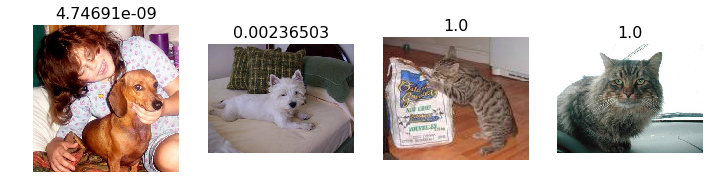

In [60]:
#1. A few correct labels at random
correct = np.where(preds == labels)[0]
idx = permutation(correct)[:n_view]
plots_idx(idx, probs[idx])

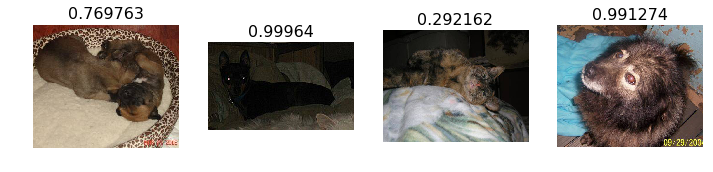

In [61]:
# 2. A few incorrect labels at random
incorrect = np.where(preds != labels)[0]
idx = permutation(incorrect)[:n_view]
plots_idx(idx, probs[idx])

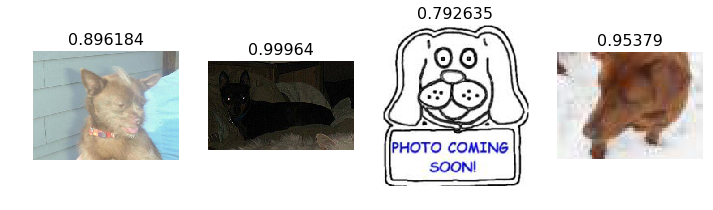

In [66]:
# 3. The images we were most confident cats, but are actually dogs
incorrect_cats = np.where((preds == 0) & (preds != labels))[0]
most_incorrect_cats = np.argsort(probs[incorrect_cats][: : -1])[:n_view]
plots_idx(incorrect_cats[most_incorrect_cats], probs[incorrect_cats][most_incorrect_cats])

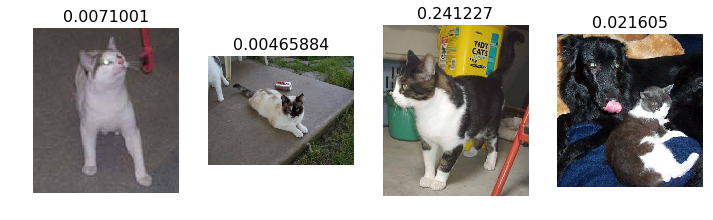

In [67]:
# 4. The images we were most confident dogs, but are actually cats
incorrect_dogs = np.where((preds == 1) & (preds != labels))[0]
most_incorrect_dogs = np.argsort(probs[incorrect_dogs][: : -1])[:n_view]
plots_idx(incorrect_dogs[most_incorrect_dogs], probs[incorrect_dogs][most_incorrect_dogs])

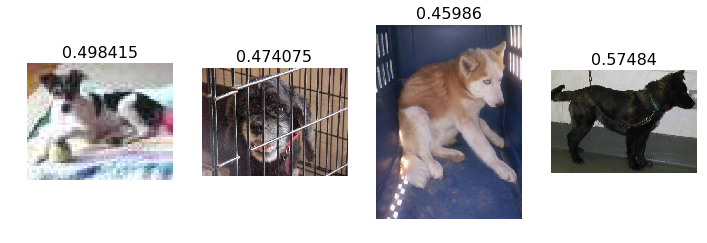

In [70]:
# 5. The most uncertain labels (id those with probability closest to 0.5)
most_uncertain = np.argsort(np.abs(probs - 0.5))
plots_idx(most_uncertain[:n_view], probs[most_uncertain[:n_view]])

## Confusion matrix

In [2]:
from sklearn.metrics import confusion_matrix

In [15]:
cm = confusion_matrix(labels, preds)

[[997   5]
 [ 29 969]]


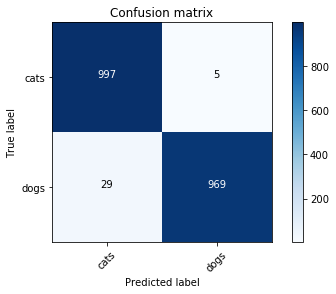

In [19]:
plot_confusion_matrix(cm, val_batches.class_indices)